In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
from src.onnx_model import YoloOnnxModel
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch import nn
import cv2
import torch
from ultralytics import YOLO
import onnxruntime as ort
import torchvision
from src.utils.vision import non_maximum_supression
from src.visualization import plot_yolo_labels
from src.transforms import xywh2xyxy, xywhn2xywh

In [3]:
CONF_THRESHOLD = 0.25
IOU_THRESHOLD = 0.

onnx_model = YoloOnnxModel("../models/detection_model.onnx")

/home/shate/.cache/pypoetry/virtualenvs/digits-detection-hppNHGvS-py3.11/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [8]:
from onnx import TensorProto, AttributeProto
from onnx.helper import make_model, make_node, make_graph, make_tensor_value_info, make_value_info
from onnx.checker import check_model
import onnx

def shape2tuple(shape):
    return tuple(getattr(d, 'dim_value', 0) for d in shape.dim)


boxes = make_tensor_value_info('boxes', TensorProto.FLOAT, [1, None, 4])
scores = make_tensor_value_info('scores', TensorProto.FLOAT, [1, 1, None])
max_output_boxes_per_class = make_tensor_value_info('max_output_boxes_per_class', TensorProto.INT64, [1])
iou_threshold = make_tensor_value_info('iou_threshold', TensorProto.FLOAT, [1])
score_threshold = make_tensor_value_info('score_threshold', TensorProto.FLOAT, [1])

selected_indices = make_tensor_value_info('selected_indices', TensorProto.INT64, [None, 3])

node = make_node('NonMaxSuppression', ['boxes', 'scores', 'max_output_boxes_per_class', 'iou_threshold', 'score_threshold'], ['selected_indices'], center_point_box=1)

graph = make_graph([node], 'nms', [boxes, scores, max_output_boxes_per_class, iou_threshold, score_threshold], [selected_indices])
nms_model = make_model(graph)
check_model(nms_model)

In [9]:
onnx.save(nms_model, "nms.onnx")

In [10]:
nms = ort.InferenceSession("nms.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

In [11]:
np.random.seed(1)

boxes = np.random.randint(0, 100, (1, 100, 4)).astype(np.float32)
scores = np.random.uniform(0, 1, (1, 1, 100)).astype(np.float32)
max_output_boxes_per_class = np.array([100], dtype=np.int64)
iou_threshold = np.array([0.95], dtype=np.float32)
score_threshold = np.array([0.5], dtype=np.float32)

preds = nms.run(
    None, 
    {
        "boxes": boxes, 
        "scores": scores, 
        "max_output_boxes_per_class": max_output_boxes_per_class,
        "iou_threshold": iou_threshold,
        "score_threshold": score_threshold
    }
)[0]

In [56]:
image = Image.open("../datasets/yolo_HWD+/images/test/42.png")
img = np.asarray(image)[..., :3]
input_image = np.copy(img)
input_tensor, ratio, pad = onnx_model.prepare_input(input_image)
outputs = onnx_model.inference(input_tensor)[0]

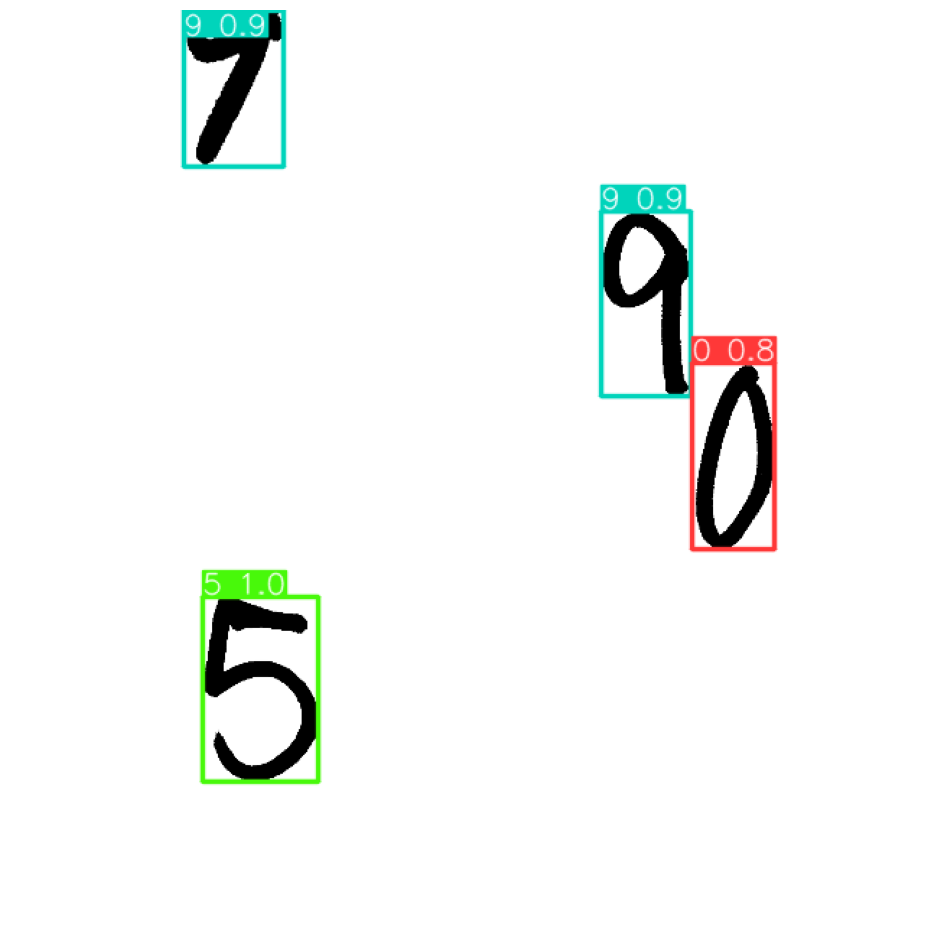

In [57]:
_ = onnx_model(img, 0.7, 0.25).visualize(plot=True)

In [58]:
boxes = outputs[:, :4].transpose(0, 2, 1)
scores = outputs[:, 4:].max(axis=1, keepdims=True)
class_ids = outputs[:, 4:].argmax(axis=1).squeeze()

iou_threshold = np.array([0.7], dtype=np.float32)
score_threshold = np.array([0.25], dtype=np.float32)

# ratio = 256/640
# boxes = boxes / ratio

In [59]:
preds = nms.run(
    None, 
    {
        "boxes": boxes, 
        "scores": scores, 
        "max_output_boxes_per_class": np.array([100], dtype=np.int64),
        "iou_threshold": iou_threshold,
        "score_threshold": score_threshold
    }
)[0]
onnx_idxs = preds[:, 2].tolist()

In [60]:
mask = scores.squeeze() > score_threshold[0]
local_idxs = non_maximum_supression(xywh2xyxy(boxes.squeeze()[mask]), scores.squeeze()[mask], iou_threshold[0])

In [61]:
onnx_boxes = boxes.squeeze()[onnx_idxs] / 256
onnx_classes = class_ids[onnx_idxs]
onnx_scores = scores.squeeze()[onnx_idxs]

In [62]:
local_boxes = boxes.squeeze()[mask][local_idxs] / 256
local_classes = class_ids[mask][local_idxs]
local_scores = scores.squeeze()[mask][local_idxs]

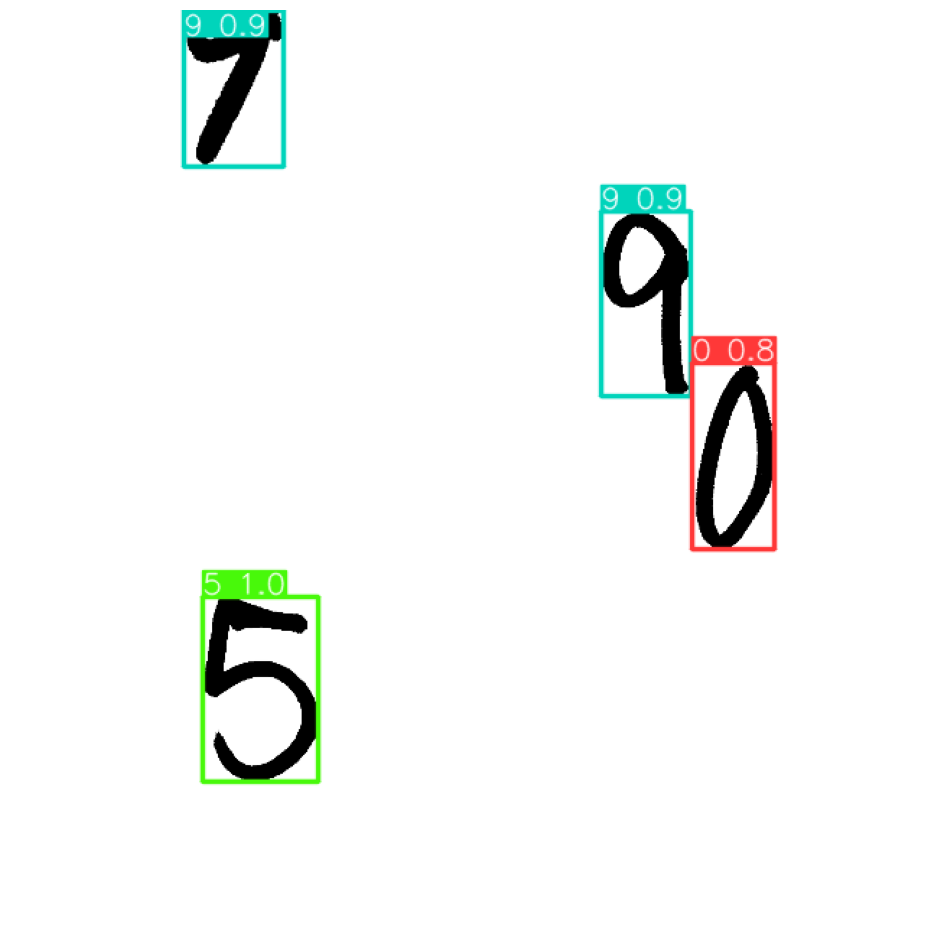

In [63]:
_ = plot_yolo_labels(img, onnx_boxes, onnx_classes, onnx_scores, plot=True)

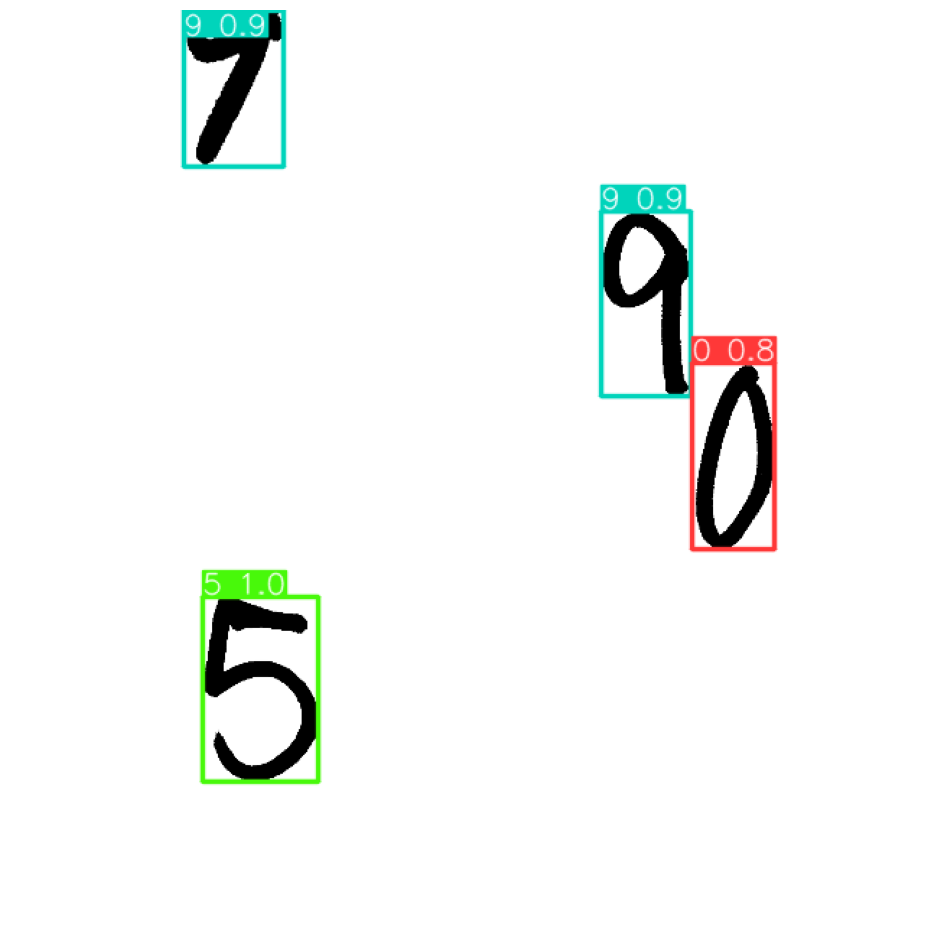

In [64]:
_ = plot_yolo_labels(img, local_boxes, local_classes, local_scores, plot=True)